# Note-5: HSC clonal structure and heterogeneity
---

**Author:** Chen Weng

**Date:** December 11, 2023

## Description

This Jupyter Notebook reproduce the all analyses in Main Fig. 3, Extended Data Fig. 7 and Supplementary Fig.6, Supplementary Data 4. 

## Related Figures
- Main Fig. 3
- Extended Data Fig. 7 
- Supplementary Fig. 6
- Supplementary Data 4


---

# Install redeemR

In [1]:
#?devtools::install_github("chenweng1991/redeemR")
#.libPaths()

# Import libraries

In [59]:
library(redeemR)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Seurat)  ## 
library(harmony)
library(ggsci)
library(ggpubr)
library(gridExtra)
library(Rmagic)
library(ggExtra)
library(viridis)
library(ggtree)
library(ggtreeExtra)
library(poolr)
library(qvalue)
library(reshape2)
# library(reshape2)
# library(ggsci)
# library(cols4all)
# library(amap)?
# library(ggdendro)
# library(treeio)
# 
# library(ggtreeExtra)
# library(RColorBrewer)
# library(qvalue)
# library(chromVAR)
# library(JASPAR2020)
# library(TFBSTools)
# library(motifmatchr)
# library(BSgenome.Hsapiens.UCSC.hg38)

# Set path

In [4]:
## set main directory to the reproducibility_pub
Dir="/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/reproducibility_pub" # Change this to your actual path **/reproducibility_pub

# Define HSC in Young-1

In [7]:
Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm<-readRDS(paste(Dir,"/data/Multiome/DN4_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm",sep="")) ## This is a Seurat object that harmonized on "Timepoints" by Reclustering_hm from redeemR

## Extended Data Fig. 7a-b

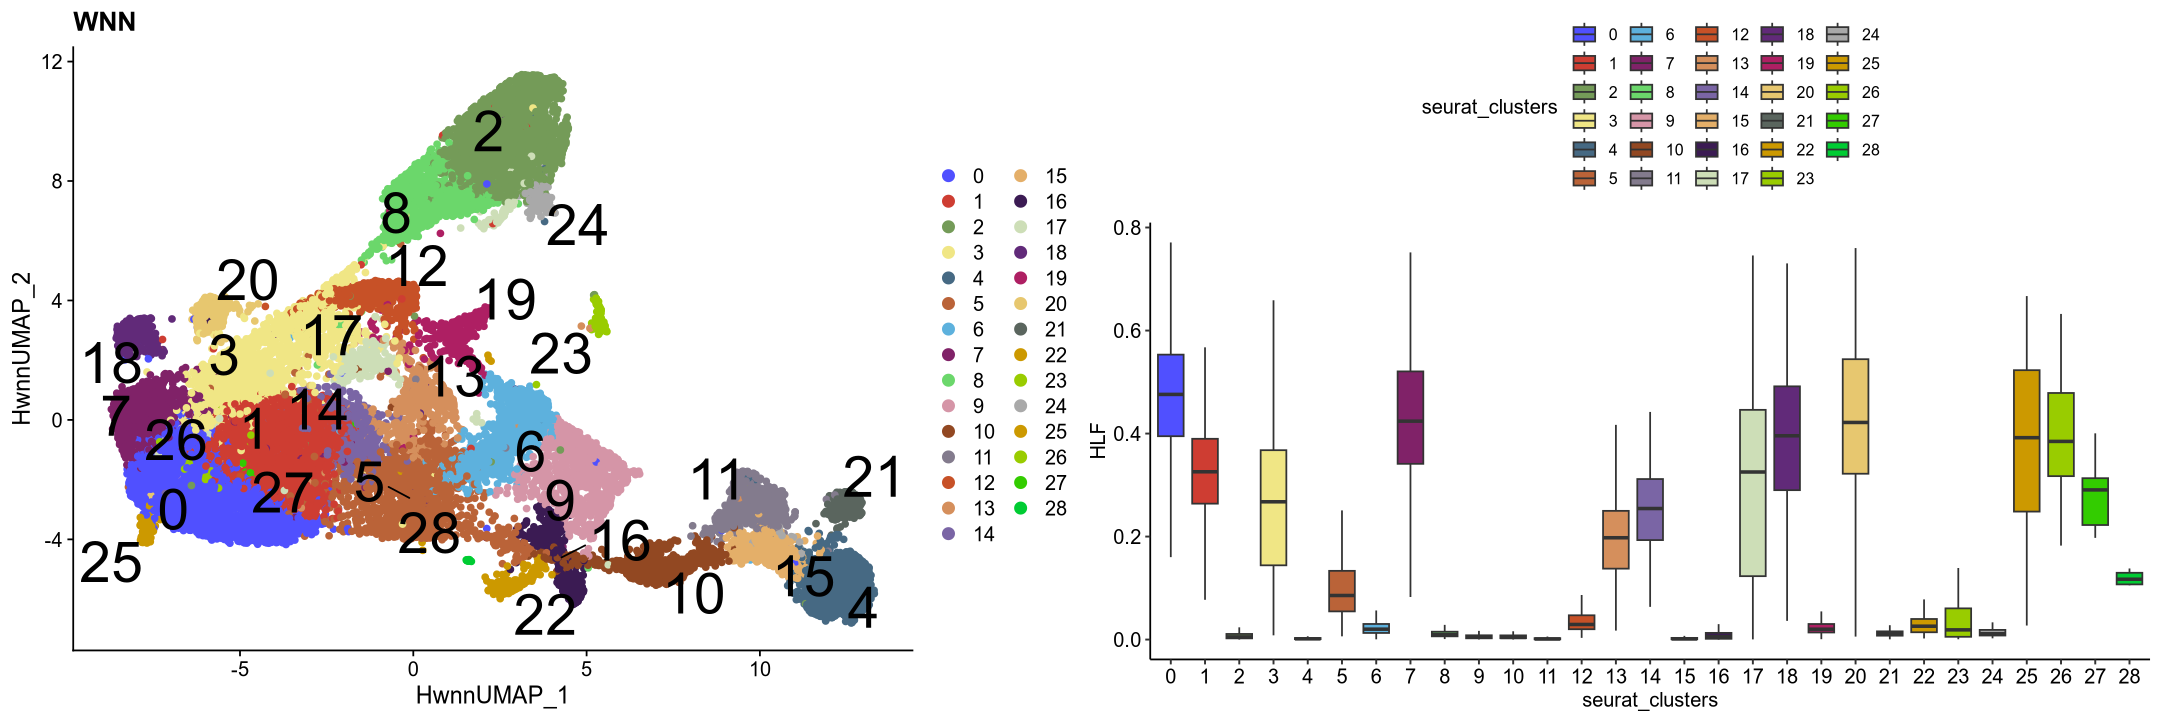

In [6]:
options(repr.plot.width=18, repr.plot.height=6,repr.plot.res=120)
p1<-DimPlot(Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm, reduction = "umap.H.wnn", label = T,pt.size = 1.5, label.size = 12, repel = TRUE) + ggtitle("WNN")+scale_color_igv()
p2<-ggplot(Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data)+aes(seurat_clusters,HLF,fill=seurat_clusters)+geom_boxplot(outlier.shape = NA)+theme_pubr()+scale_fill_igv()
grid.arrange(p1,p2,nrow=1)

In [8]:
# Run Magic for HLF and CRHBP and CD34, optional
data<-Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@assays$SCT@data %>% t 
data_MAGIC_HLF <- magic(data, t=4, genes="HLF")
data_MAGIC_CHRBP <- magic(data, t=4, genes="CRHBP")
data_MAGIC_CD34 <- magic(data, t=4, genes="CD34")

## Extended Data Fig. 7c-d

Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a
  factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a
  factor?”


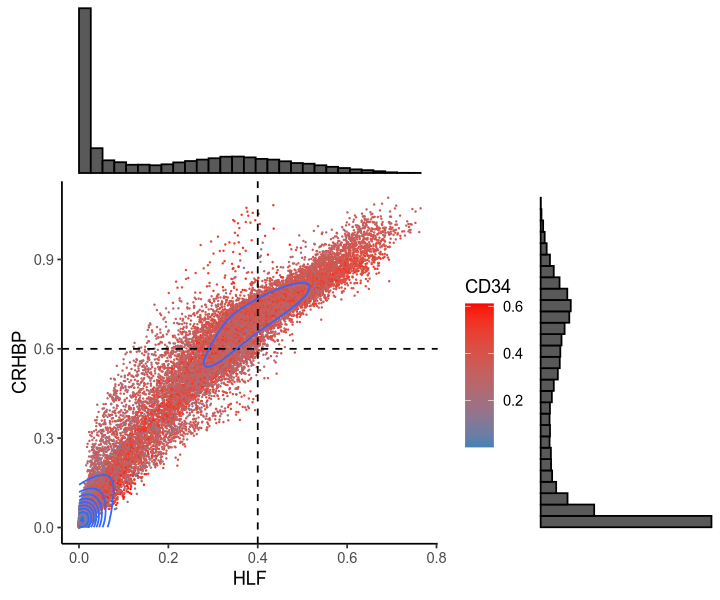

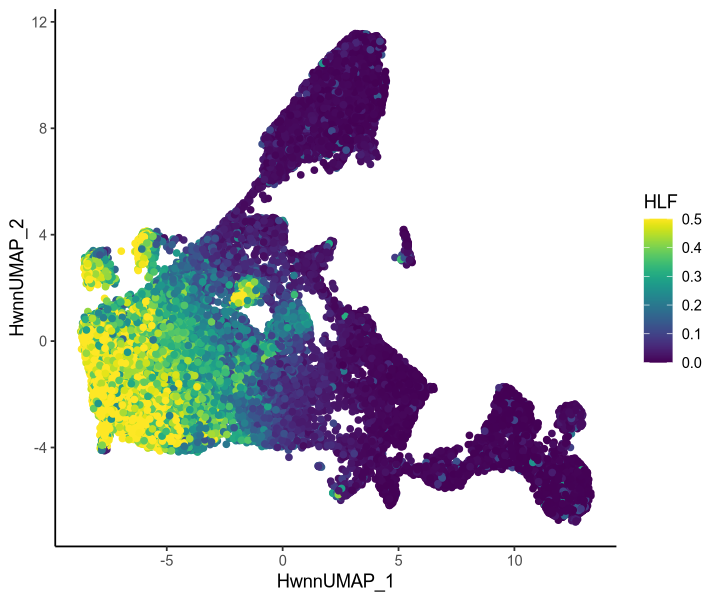

In [10]:
## Plot HLF-CRHBP that defines rigrous HSC
datatoplot<-Tomerge_v2(data_MAGIC_HLF$result,data_MAGIC_CHRBP$result) %>% Tomerge_v2(.,data_MAGIC_CD34$result)
options(repr.plot.width=6, repr.plot.height=5,repr.plot.res=120)
p<-ggplot(datatoplot)+aes(HLF,CRHBP,color=CD34)+geom_point(size=0.05)+theme_classic()+geom_vline(xintercept = 0.4,linetype=2)+geom_hline(yintercept = 0.6,linetype=2)+scale_color_gradient(low="steelblue",high="red")+geom_density_2d()
ggMarginal(p, type = "histogram", size=2)
## Plot HLF levels on UMAP
datatoplot<-Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.wnn@cell.embeddings %>% Tomerge_v2(.,data_MAGIC_HLF$result) %>% Tomerge_v2(.,data_MAGIC_CHRBP$result) %>% 
Tomerge_v2(.,data_MAGIC_CD34$result)
ggplot(datatoplot)+aes(HwnnUMAP_1,HwnnUMAP_2,color=HLF)+geom_point()+theme_classic()+scale_color_viridis(limit=c(0,0.5),oob=scales::squish)

In [11]:
## Define rigrous HSC using cluster+ HLF/CRHBP signature,the defined rigrous HSC has already been stored in Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data$Rig.HSC
## Because magic introduce some randomeness, when reproducing, there might be slight differences. 
meta.data<-Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data %>% 
 mutate(Rig.HSC=ifelse(seurat_clusters %in% c(0,1,3,7,17,18,20,25,26,27) & HLF>0.4 & CRHBP>0.6 & STD.CellType %in% c("HSC","MKP","MPP"),"HSC","")) 

In [12]:
print("Rigorous HSC ")
Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data %>% subset(.,Rig.HSC=="HSC") %>% .$TimePoint %>% table

[1] "Rigorous HSC "


.
  T1   T2 
2992 2401 

## Extended Data Fig. 7e

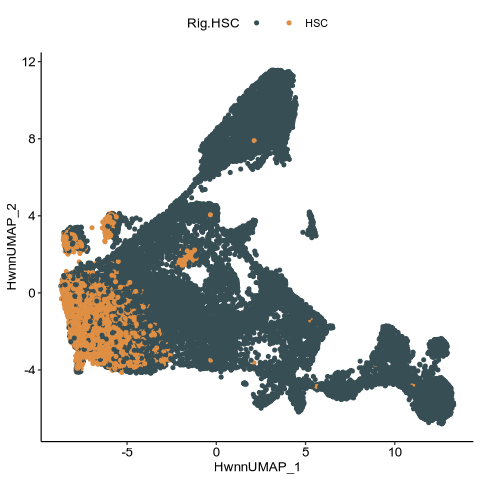

In [13]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=80)
Tomerge_v2(Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.wnn@cell.embeddings,Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data) %>%
ggplot()+geom_point(aes(HwnnUMAP_1,HwnnUMAP_2,color=Rig.HSC))+scale_color_jama()+theme_pubr()


In [15]:
Young1_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno<-readRDS(paste(Dir,"/data/Multiome/DN4_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno",sep=""))
Young1_T2_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno<-readRDS(paste(Dir,"/data/Multiome/DN4_T2_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno",sep=""))

In [16]:
Rig.HSCs<-subset(Young1_HSPC_HSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data,Rig.HSC=="HSC") %>% row.names

In [17]:
## Change meta names
T1.meta<-Young1_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@meta.data
T2.meta<-Young1_T2_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@meta.data
row.names(T1.meta)<-paste(row.names(Young1_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@meta.data),"_T1",sep="")
row.names(T2.meta)<-paste(row.names(Young1_T2_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@meta.data),"_T2",sep="")

In [18]:
## Make meta 
meta<-rbind(T1.meta,T2.meta)
meta$Cells<-row.names(meta)
meta<-meta %>% mutate(Rig.HSC=ifelse(Cells %in% Rig.HSCs,"HSC","")) %>% .[,c("Cells","Rig.HSC","STD.CellType")]

meta$NewLabel<-apply(meta,1,function(x){
    if(x[2]=="HSC"){
        return("HSC")
      }else if(x[3] %in% c("CD4","Mono","B","CD8","NK","cDC","Plasma")){
        return("Differentiated_cells")
      }else if (x[3] %in% c("CMP","MKP","MEP","CLP","ProB","GMP","EryP","MDP","LMPP")){
        return("Progenitors")  
      }else{
        return(NA)
    }
}) 

In [19]:
## Change count names
T1.count<-Young1_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@assays$RNA@counts %>% as.matrix() 
T2.count<-Young1_T2_BMMC_HSPC_HSC_Multiome_wrapper.filtered.anno@assays$RNA@counts %>% as.matrix() 
colnames(T1.count)<-paste(colnames(T1.count),"_T1",sep="")
colnames(T2.count)<-paste(colnames(T2.count),"_T2",sep="")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.9 GiB”


In [20]:
count.T1T2<-Tomerge_v2(T1.count,T2.count)

In [21]:
# create Seurat v3 assays
# options(Seurat.object.assay.version = "v3")
T1T2.all.seurat <- CreateSeuratObject(counts = as(count.T1T2, "sparseMatrix"), project = "T2T2all", min.cells = 3, min.features = 200)
T1T2.all.seurat <- NormalizeData(T1T2.all.seurat)
all.genes <- rownames(T1T2.all.seurat)
T1T2.all.seurat <- ScaleData(T1T2.all.seurat, features = all.genes)

Centering and scaling data matrix



In [22]:
data<-T1T2.all.seurat@assays$RNA@data %>% as.matrix %>% t 

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 9.5 GiB”


In [23]:
## Check independent HSC markers that are not used in HSC defining
data_MAGIC_HLF <- magic(data, t=4, genes="HLF")
data_MAGIC_CHRBP <- magic(data, t=4, genes="CRHBP")
data_MAGIC_CD34 <- magic(data, t=4, genes="CD34")

In [24]:
data_MAGIC_MECOM <- magic(data, t=4, genes="MECOM")
data_MAGIC_HOPX <- magic(data, t=4, genes="HOPX")
data_MAGIC_AVP <- magic(data, t=4, genes="AVP")

In [25]:
data_MAGIC_RBPMS <- magic(data, t=4, genes="RBPMS")
data_MAGIC_MLLT3 <- magic(data, t=4, genes="MLLT3")

## Main Fig. 3b

In [54]:
HSCMarkers<- Tomerge_v2(meta,data_MAGIC_CD34$result)%>% Tomerge_v2(.,data_MAGIC_HLF$result)%>% Tomerge_v2(.,data_MAGIC_CHRBP$result)%>% Tomerge_v2(.,data_MAGIC_MECOM$result) %>% Tomerge_v2(.,data_MAGIC_HOPX$result)%>% Tomerge_v2(.,data_MAGIC_AVP$result) %>% Tomerge_v2(.,data_MAGIC_RBPMS$result)%>% Tomerge_v2(.,data_MAGIC_MLLT3$result)

In [55]:
HSCMarkers$Cells<-row.names(HSCMarkers)

In [56]:
HSCMarkers<-HSCMarkers[,c("Cells","Rig.HSC","STD.CellType","CD34","HLF","CRHBP","MECOM","HOPX","AVP","RBPMS","MLLT3")]

HSCMarkers$NewLabel<-apply(HSCMarkers,1,function(x){
    if(x[2]=="HSC"){
        return("HSC")
      }else if(x[3] %in% c("CD4","Mono","B","CD8","NK","cDC","Plasma")){
        return("Differentiated_cells")
      }else if (x[3] %in% c("CMP","MKP","MEP","CLP","ProB","GMP","EryP","MDP","LMPP")){
        return("Progenitors")  
      }else{
        return(NA)
    }
}) 

In [57]:
datatoplot<-subset(HSCMarkers,!is.na(NewLabel)) %>% reshape2::melt(.,id.vars=c("Cells","Rig.HSC","STD.CellType","NewLabel")) 
datatoplot$NewLabel<-factor(datatoplot$NewLabel,levels=c('Differentiated_cells','Progenitors','HSC'))

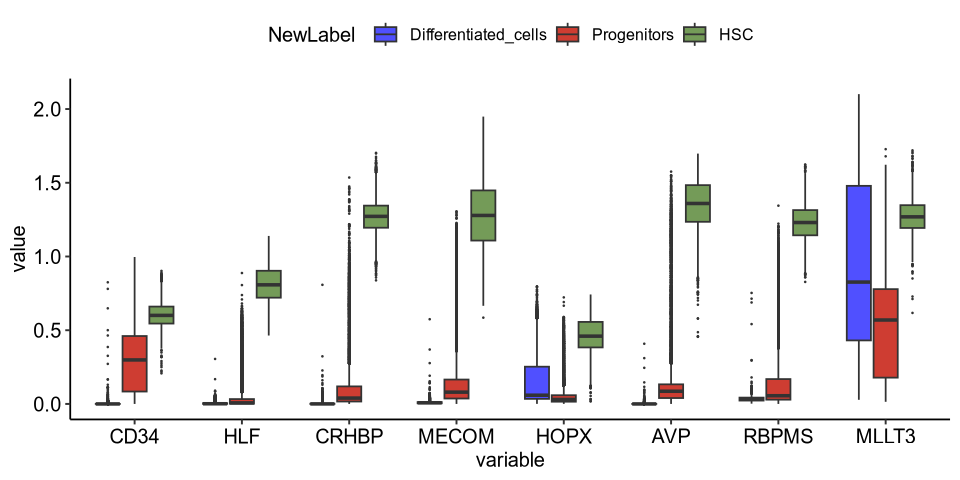

In [58]:
options(repr.plot.width=8, repr.plot.height=4,repr.plot.res=120)
ggplot(datatoplot)+aes(variable,value,fill=NewLabel)+geom_boxplot(outlier.size = 0.1)+theme_pubr()+
scale_fill_igv()

In [59]:
for (gene in c("CD34","HLF","CRHBP","MECOM","HOPX","AVP","RBPMS","MLLT3")){
dataset<-subset(datatoplot,variable==gene)
res<-wilcox.test(subset(dataset,NewLabel=="HSC")$value,subset(dataset,NewLabel=="Progenitors")$value,alternative = "greater")
print(gene)
print(res)
}

[1] "CD34"

	Wilcoxon rank sum test with continuity correction

data:  subset(dataset, NewLabel == "HSC")$value and subset(dataset, NewLabel == "Progenitors")$value
W = 74162404, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0

[1] "HLF"

	Wilcoxon rank sum test with continuity correction

data:  subset(dataset, NewLabel == "HSC")$value and subset(dataset, NewLabel == "Progenitors")$value
W = 83006034, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0

[1] "CRHBP"

	Wilcoxon rank sum test with continuity correction

data:  subset(dataset, NewLabel == "HSC")$value and subset(dataset, NewLabel == "Progenitors")$value
W = 82898214, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0

[1] "MECOM"

	Wilcoxon rank sum test with continuity correction

data:  subset(dataset, NewLabel == "HSC")$value and subset(dataset, NewLabel == "Progenitors")$value
W = 82676406, p-value < 2.2e-16
alternative hypothesis

# HSC reclusteringin Young-1

## Main Fig. 3c

In [7]:
Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm<-readRDS(paste(Dir,"/data/Multiome/DN4_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm",sep=""))

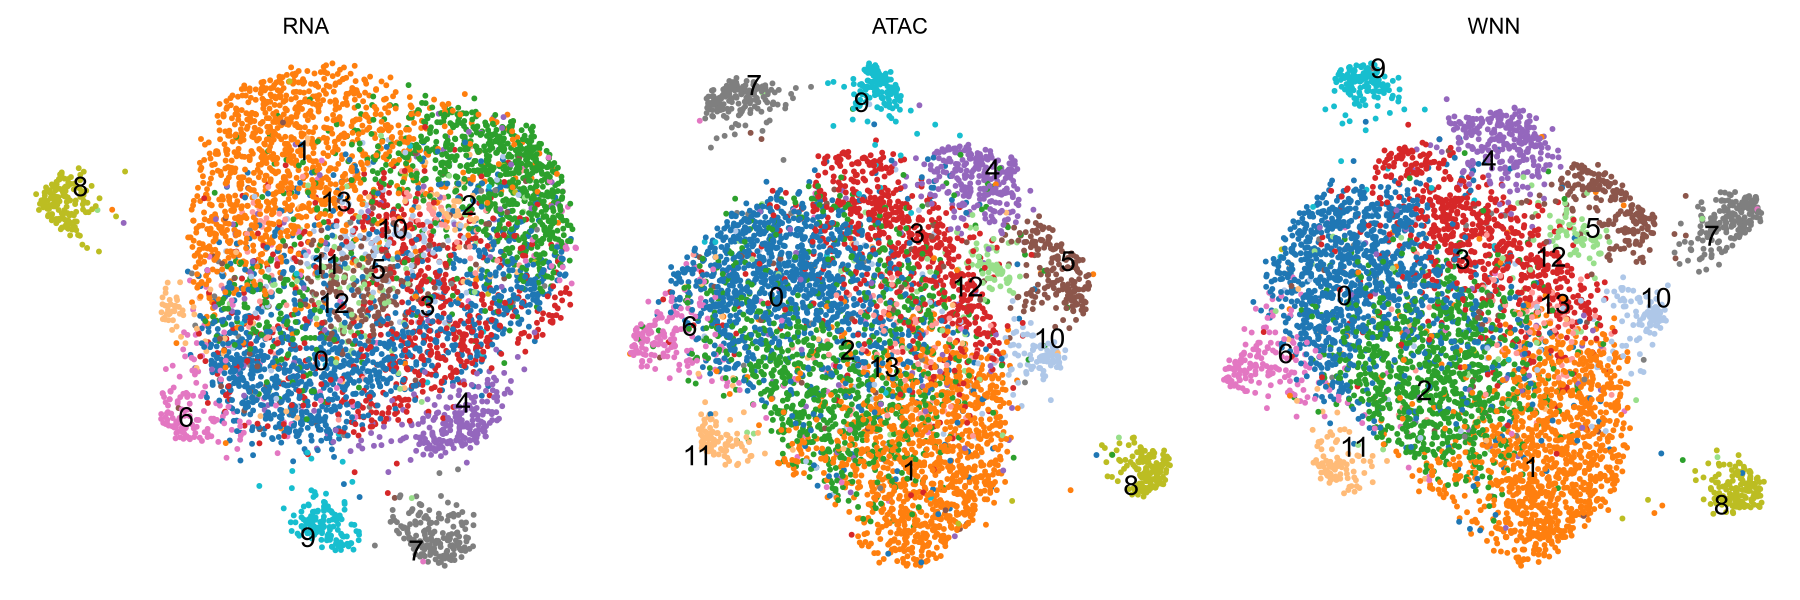

In [63]:
options(repr.plot.width=15, repr.plot.height=5,repr.plot.res=120)
p1 <- DimPlot(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, reduction = "umap.H.rna",  label = T, label.size = 6, repel = TRUE,pt.size=1) + ggtitle("RNA")+scale_color_d3(palette="category20")+theme_void()
p2 <- DimPlot(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, reduction = "umap.H.atac",  label = T, label.size = 6, repel = TRUE,pt.size=1) + ggtitle("ATAC")+scale_color_d3(palette="category20")+theme_void()
p3 <- DimPlot(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, reduction = "umap.H.wnn", label = T, label.size = 6, repel = TRUE,pt.size=1) + ggtitle("WNN")+scale_color_d3(palette="category20")+theme_void()
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))

## Extended Data Fig. 7f

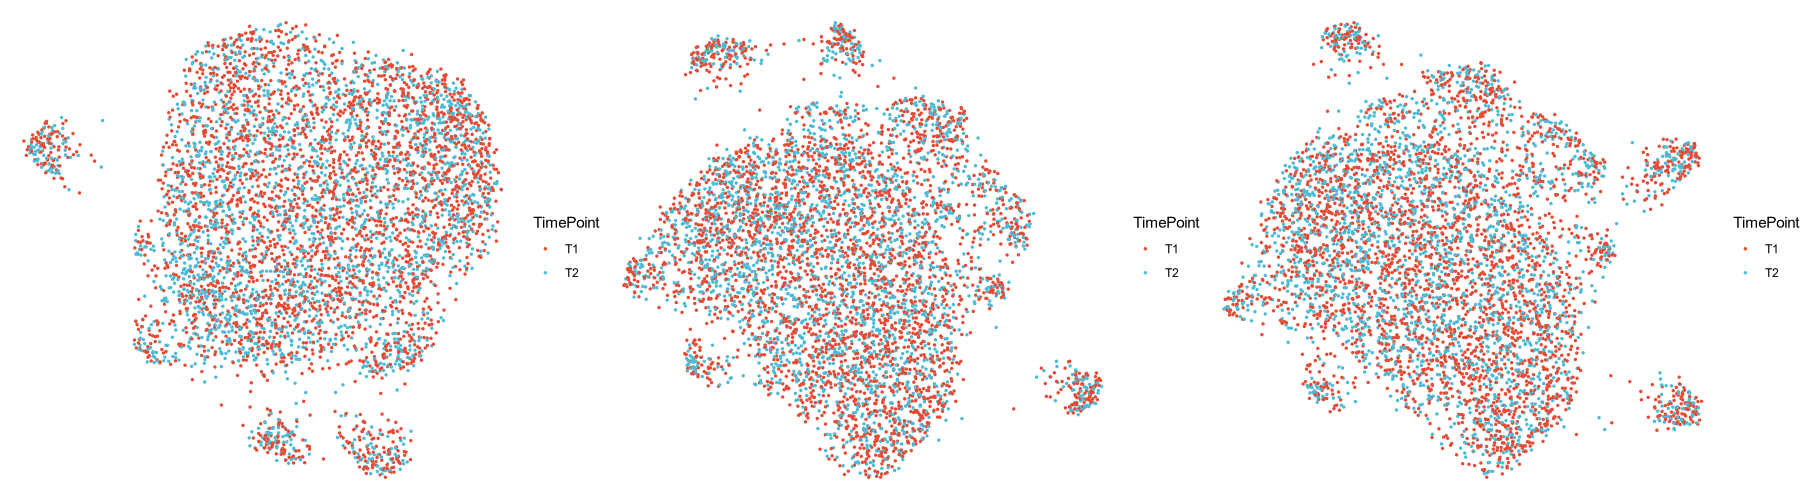

In [65]:
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=5,repr.plot.res=100)
ColT1T2<-pal_npg("nrc",alpha=1)(2)
p1<-Tomerge_v2(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.rna@cell.embeddings,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data) %>% ggplot()+aes(HrnaUMAP_1,HrnaUMAP_2,color=TimePoint)+geom_point(size=0.5)+theme_pubr()+scale_color_manual(values=ColT1T2)+theme_void()
p2<-Tomerge_v2(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.atac@cell.embeddings,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data) %>% ggplot()+aes(HatacUMAP_1,HatacUMAP_2	,color=TimePoint)+geom_point(size=0.5)+theme_pubr()+scale_color_manual(values=ColT1T2)+theme_void()
p3<-Tomerge_v2(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.wnn@cell.embeddings,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data) %>% ggplot()+aes(HwnnUMAP_1,HwnnUMAP_2,color=TimePoint)+geom_point(size=0.5)+theme_pubr()+scale_color_manual(values=ColT1T2)+theme_void()
grid.arrange(p1,p2,p3,nrow=1)

# HSC heterogenetity

## Supplementary Fig. 6b

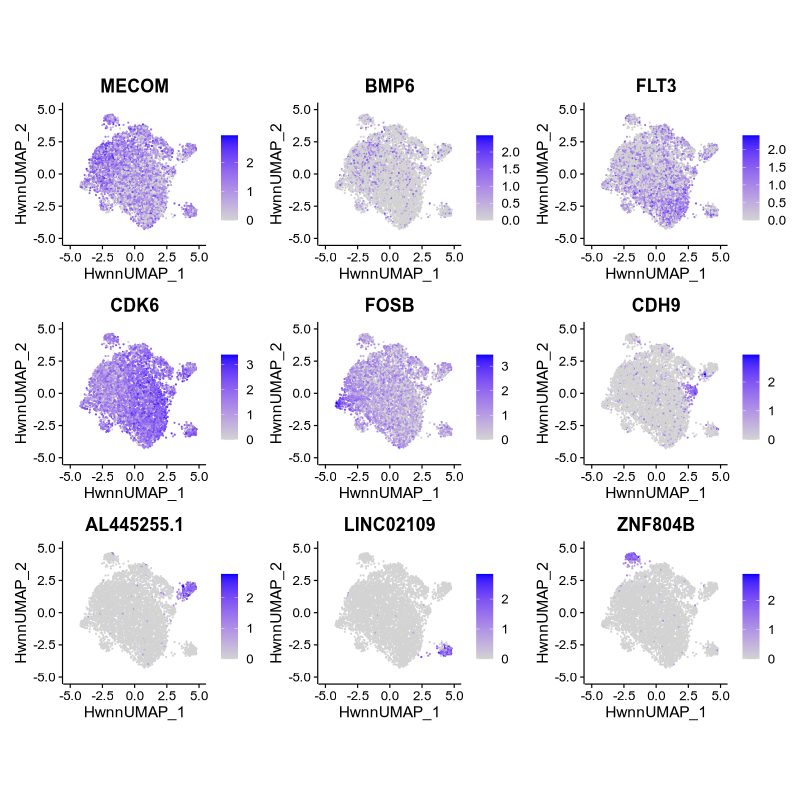

In [67]:
## Show some genes on the wnnUMAP
options(repr.plot.width=10, repr.plot.height=10,repr.plot.res=80)
DefaultAssay(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm) <- "SCT"
FeaturePlot(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, features = c("MECOM","BMP6","FLT3","CDK6","FOSB","CDH9","AL445255.1","LINC02109","ZNF804B"),reduction = "umap.H.wnn",coord.fixed = T)


In [68]:
DefaultAssay(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm) <- "SCT"
Young1_T1T2_HSC.markers <- FindAllMarkers(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
Young1_T1T2_HSC.markers %>% group_by(cluster) %>% top_n(n = -6, wt = p_val_adj) %>% subset(.,p_val_adj<0.01)-> top6

Calculating cluster 0

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



## Extended Data Fig. 7g

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


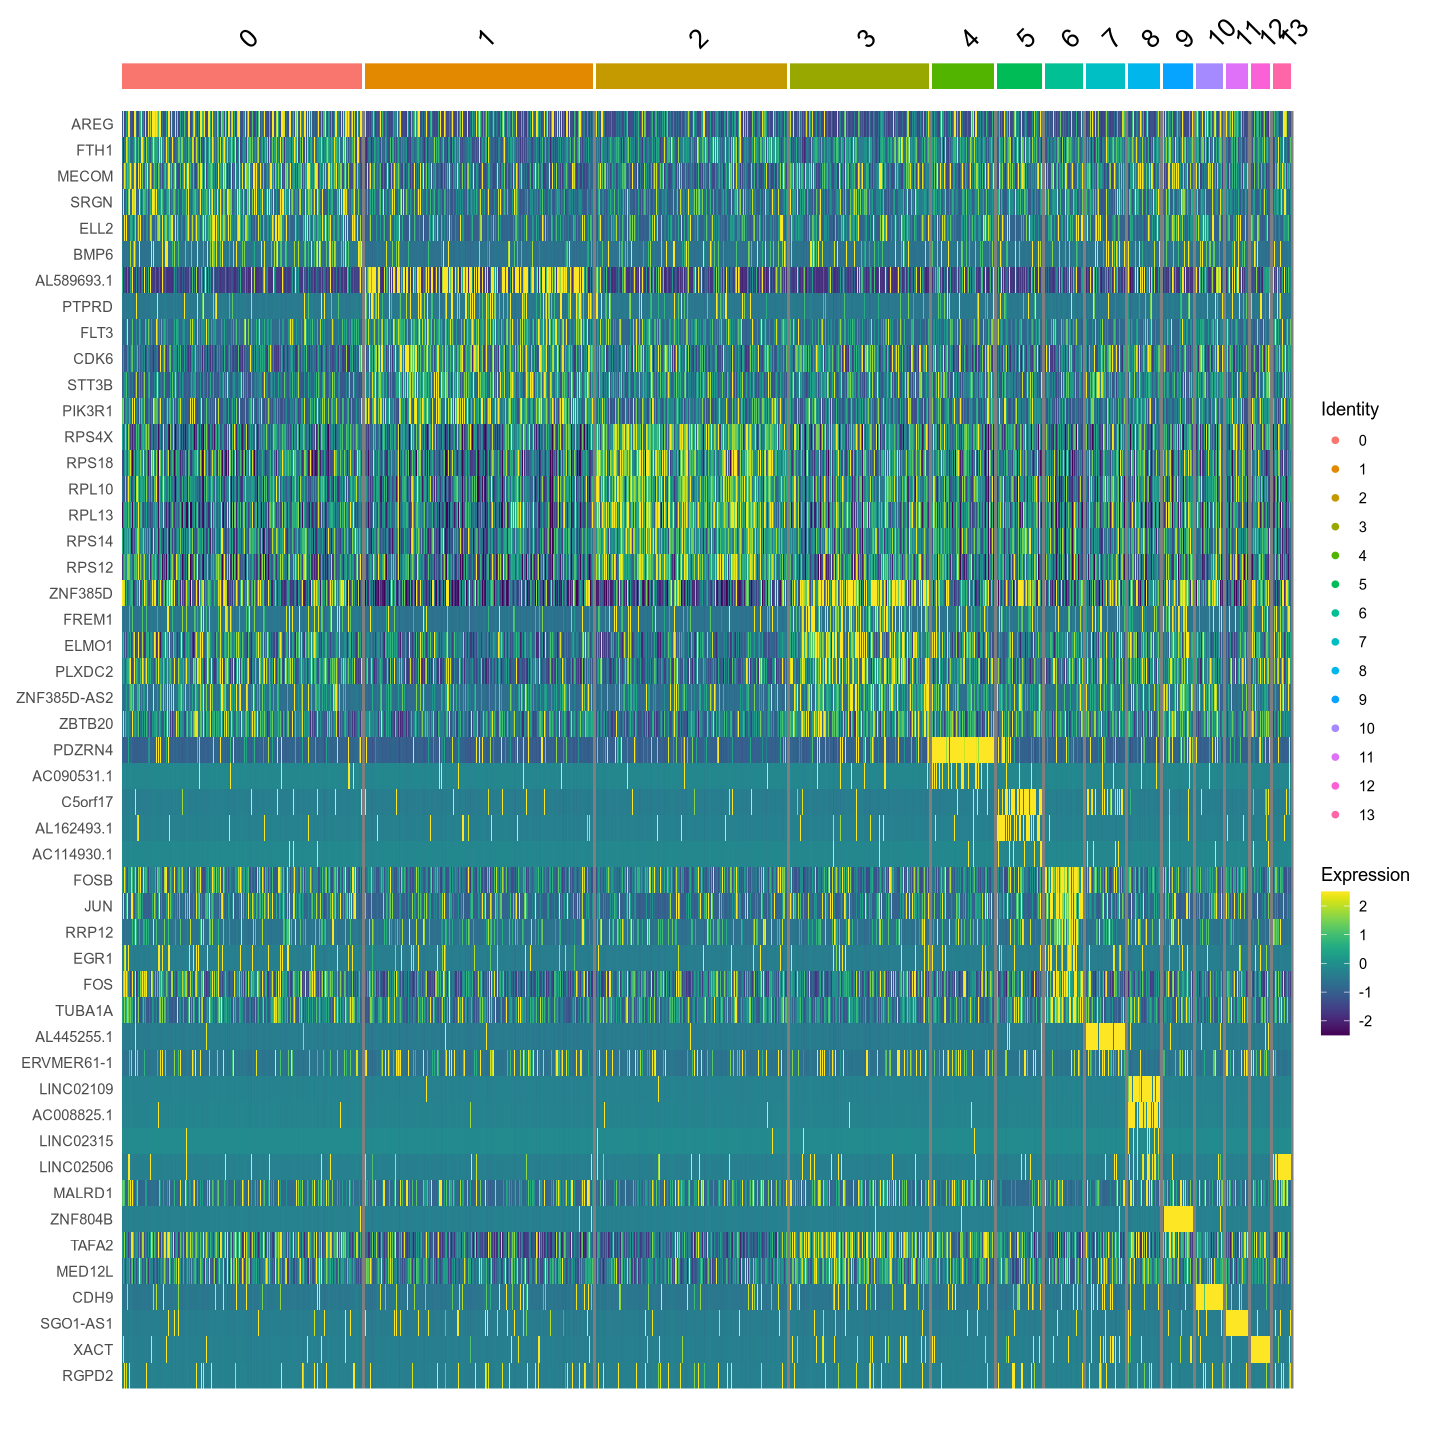

In [72]:
library(viridis)
options(repr.plot.width=12, repr.plot.height=12,repr.plot.res=120)
DoHeatmap(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm, features = top6$gene) +scale_fill_viridis()+
theme(panel.spacing = unit(100, "lines"))

## HSC subpopulation motif

In [12]:
library(chromVAR)
library(Signac)
library("BSgenome.Hsapiens.UCSC.hg38")
library(TFBSTools)
library(JASPAR2020)
library(motifmatchr)
library(ggseqlogo)

In [14]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)
Motif.dic<-sapply(pfm, function(x){x@name})

In [15]:
# add motif information
DefaultAssay(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm) <- 'ATAC'
Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm <- AddMotifs(
  object = Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  pfm = pfm
)

Building motif matrix

Finding motif positions

Creating Motif object



In [16]:
## run chromvar
DefaultAssay(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm) <- 'ATAC'
ChromVar.res<- RunChromVAR(
  object = Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [17]:
## Differential motifs
DefaultAssay(ChromVar.res) <- 'chromvar'
differential.activity <- FindAllMarkers(object = ChromVar.res,only.pos = F,mean.fxn = rowMeans,fc.name = "avg_diff")

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [19]:
differential.activity.enrich<-subset(differential.activity,avg_diff>0)
differential.activity.enrich$TF<-Motif.dic[row.names(differential.activity.enrich)]
chromVar.z<-t(ChromVar.res@assays$chromvar@data) 
differential.activity.enrich.sig<-subset(differential.activity.enrich,p_val_adj<0.2)
differential.activity.enrich.sig<-differential.activity.enrich.sig %>% mutate(Name=paste("HSC_",cluster,"-",gene,sep=""))

In [20]:
#motif.datatoplot<-
Tomerge_v2(chromVar.z,ChromVar.res@meta.data[,"seurat_clusters",drop=F]) %>% group_by(seurat_clusters) %>%
dplyr::summarise_all(mean) %>% as.data.frame %>% mutate(seurat_clusters=paste("HSC",seurat_clusters,sep="_")) %>% 
reshape2::melt(.) %>% subset(.,variable %in% differential.activity.enrich.sig$gene) %>% mutate(Name=paste(seurat_clusters,variable,sep="-")) %>%
merge(.,differential.activity.enrich.sig[,c("Name","p_val_adj","TF")],all.x=T) ->motif.datatoplot

# Add tag
motif.datatoplot$p_val_adj[is.na(motif.datatoplot$p_val_adj)]<-1
Tag<-c()
Tag[which(motif.datatoplot$p_val_adj<0.001)]<-"***"
Tag[which(motif.datatoplot$p_val_adj>=0.001 & motif.datatoplot$p_val_adj<0.01)]<-"**"
Tag[which(motif.datatoplot$p_val_adj>=0.01 & motif.datatoplot$p_val_adj<0.2)]<-"*"
Tag[which(motif.datatoplot$p_val_adj>=0.2)]<-""
motif.datatoplot$Tag<-Tag

## Add order
motif.datatoplot$seurat_clusters<-factor(motif.datatoplot$seurat_clusters,
    levels=c("HSC_0","HSC_2","HSC_6","HSC_9","HSC_11","HSC_1","HSC_3","HSC_4","HSC_12","HSC_5","HSC_7","HSC_8","HSC_10"))

##Motif order
differential.activity.enrich.sig$cluster<-factor(differential.activity.enrich.sig$cluster,
levels=c("0","2","6","9","11","1","3","4","12","5","7","8","10"))
differential.activity.enrich.sig<-differential.activity.enrich.sig[order(differential.activity.enrich.sig$cluster),] 
MotifOrder<-differential.activity.enrich.sig$gene %>% unique
motif.datatoplot$variable<-factor(motif.datatoplot$variable,levels=rev(MotifOrder))

Using seurat_clusters as id variables



In [36]:
motifMatrixToplot<-sapply(rev(levels(motif.datatoplot$variable)),function(x){pfm[[x]]@profileMatrix})
names(motifMatrixToplot)<-paste(Motif.dic[names(motifMatrixToplot)],sep="_")
# options(repr.plot.width=1, repr.plot.height=80,repr.plot.res=100)
p.logo<-ggseqlogo(motifMatrixToplot,ncol=1)+theme_void()

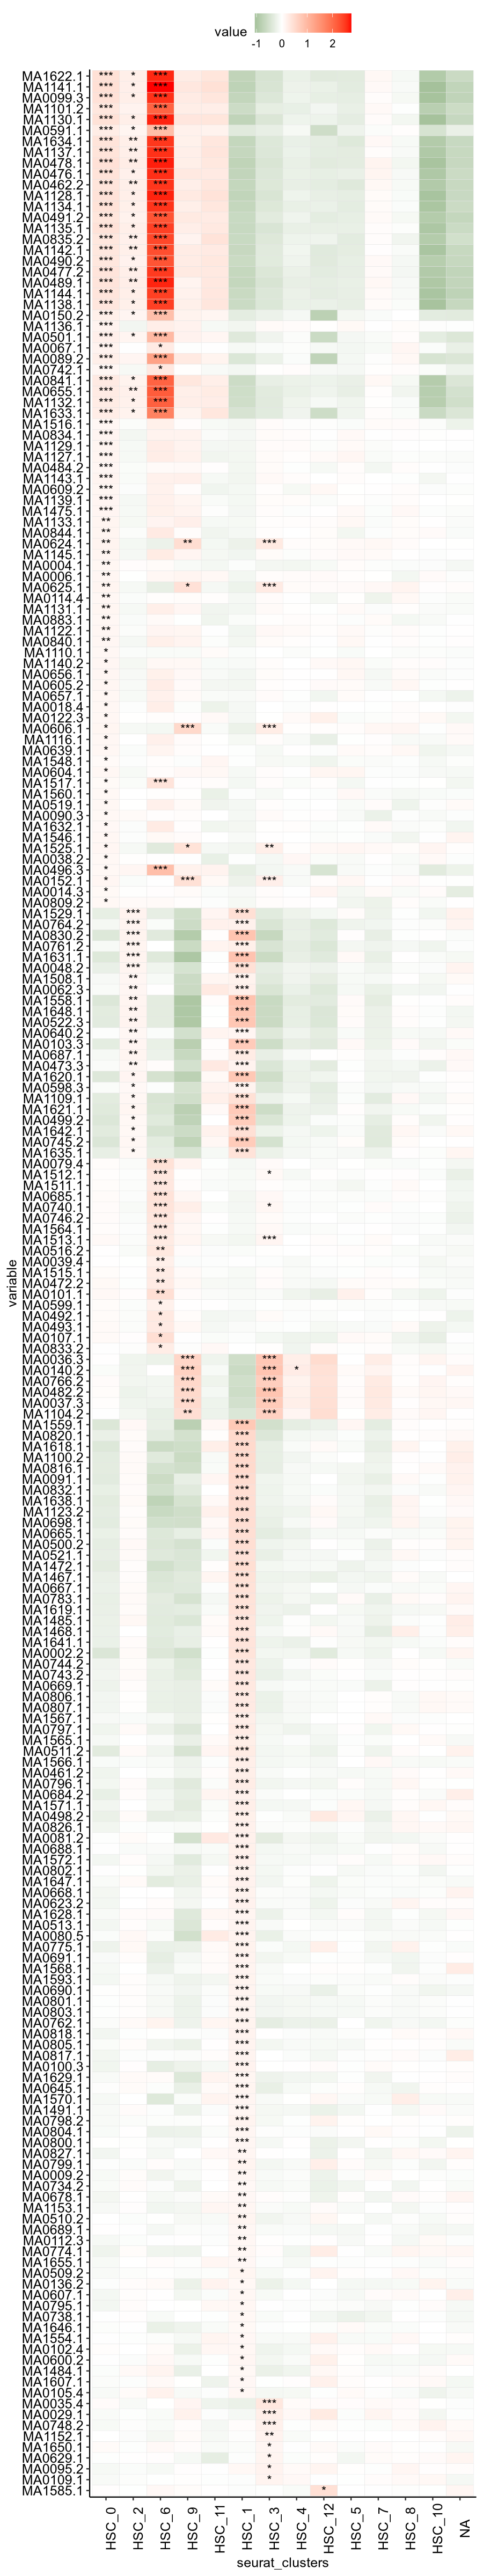

In [76]:
options(repr.plot.width=6, repr.plot.height=32,repr.plot.res=150)
ggplot(motif.datatoplot)+aes(seurat_clusters,variable,fill=value,label=Tag)+geom_tile(color="grey90")+
scale_fill_gradient2(high="red",mid="white",low="darkgreen")+geom_text()+theme_pubr()+theme(axis.text.x = element_text(angle=90))


In [58]:
differential.activity.enrich.top2<-differential.activity.enrich %>%  group_by(cluster) %>%  top_n(.,2)

Selecting by TF


In [65]:
differential.activity.enrich.top2 %>% head

p_val        avg_diff  pct.1 pct.2 p_val_adj    cluster gene     TF        
1 1.754877e-06 0.1744248 0.543 0.485 1.309138e-03 0       MA0844.1 XBP1      
2 7.719191e-04 0.1102269 0.527 0.490 5.758516e-01 0       MA1597.1 ZNF528    
3 5.242357e-11 0.2150665 0.558 0.466 3.910798e-08 1       MA1628.1 Zic1::Zic2
4 1.284122e-08 0.1968153 0.541 0.471 9.579550e-06 1       MA1629.1 Zic2      
5 6.459401e-04 0.1151677 0.549 0.483 4.818713e-01 2       MA1121.1 TEAD2     
6 5.543730e-03 0.1029203 0.542 0.490 1.000000e+00 2       MA0093.3 USF1

## Supplementary Fig. 6b

In [69]:
## JASPAR2020 motifs MA1622.1(Smad2::Smad3); MA0029.1(Mecom);MA1141.1(FOS::JUND); MA0150.2(Nfe2l2)
Motif.example<-c("MA1622.1","MA0029.1","MA1141.1","MA0150.2")

In [73]:
## Plot examples of the differential motifs 
ps<-list()
for(i in 1: length(Motif.example)){
p<-FeaturePlot(
  object = ChromVar.res,reduction="umap.H.wnn",
  features = Motif.example[i],
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.5,
)+ggtitle(Motif.example[i])+
          theme_void()+scale_color_gradient(low="lightgrey",high="darkred")
ps<-c(ps,list(p))
}

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


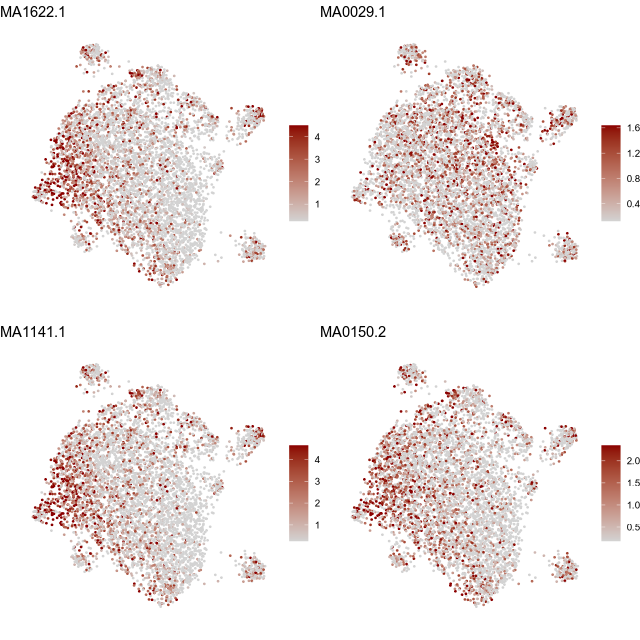

In [74]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=80)
grid.arrange(grobs=ps)

# HSC clonal structure

In [5]:
Young1_T1T2_BMMC_HSPC_HSC_mitoTracing.sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN4T1T2_BMMC_HSPC_HSC_mitoTracing.sensitive",sep=""))

In [8]:
## Step1, create RigHSC redeemR object
Young1_T1T2_RigHSC_redeemR.sensitive<-Subset_redeemR(Young1_T1T2_BMMC_HSPC_HSC_mitoTracing.sensitive,Cells=Translate_simple_RNA2ATAC(row.names(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data)))

[1] "Raw slots are skipped: -GTsummary.filtered, -V.fitered.list, "


The following `from` values were not present in `x`: 1, 2, 3



In [19]:
## Step2, LSI clonal clustering
data(CellPCT)
V.weight<-data.frame(weight=1-CellPCT$muRate)
V.weight$Variants<-paste("Variants",gsub("_","",CellPCT$Variant),sep="")
Young1_T1T2_RigHSC_redeemR.sensitive<-SeuratLSIClustering(Young1_T1T2_RigHSC_redeemR.sensitive,lsidim=2:50,rmvariants=c("Variants310TC","Variants3109TC","Variants5764CT")) # Remove the three variants that show recurrent high frequency, to avoid in paralell evolution bias
Young1_T1T2_RigHSC_redeemR.sensitive<-AddDist(Young1_T1T2_RigHSC_redeemR.sensitive,weightDF=V.weight,LSIdist=T,dim=2:50)

[1] "Seurat5 is on, convert data structure to v3"


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

20:24:34 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

20:24:34 Read 4897 rows and found 49 numeric columns

20:24:34 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

20:24:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:24:35 Writing NN index file to temp file /tmp/RtmputE3gJ/file8bd74a0fc582

20:24:35 Searching Annoy index using 1 thread, search_k = 3000

20:24:37 Annoy recall = 100%

20:24:39 Commencing smooth kNN distance calibration using 1 thread
 with targe

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4897
Number of edges: 190710

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9293
Number of communities: 40
Elapsed time: 0 seconds
[1] "Some variant i weight is not found in cell-variant matrix, use 1"
[1] "Weight vector matches well with the Cell-Variant matrix, continue..."


jaccard distances added

dice distances added

3wjaccard distances added

weighted jaccard distances added

weighted cosine distances added

LSI distances added



In [12]:
## Step 3 visulize the clonal clustering
Young1_T1T2_RigHSC_redeemR.sensitive<-AddDatatoplot_clustering(Young1_T1T2_RigHSC_redeemR.sensitive)

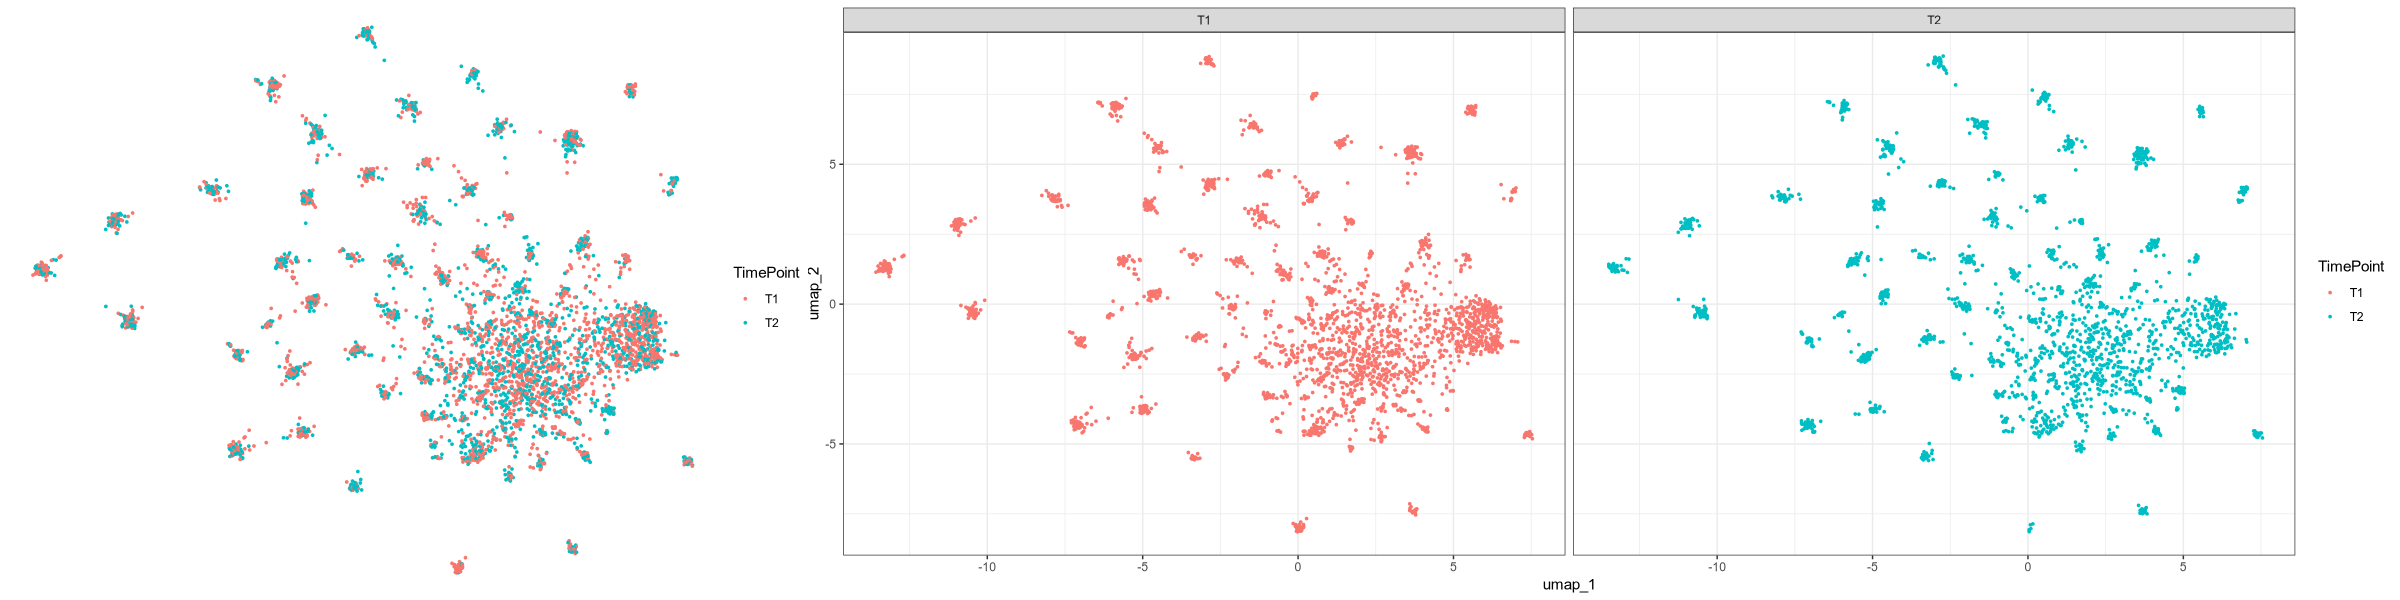

In [16]:
options(repr.plot.width=24, repr.plot.height=6,repr.plot.res=100)
p1<-Young1_T1T2_RigHSC_redeemR.sensitive@DataToplotList@clustering %>% ggplot()+aes(umap_1,umap_2,color=TimePoint)+geom_point(size=0.6)+theme_void()
p2<-Young1_T1T2_RigHSC_redeemR.sensitive@DataToplotList@clustering %>% ggplot()+aes(umap_1,umap_2,color=TimePoint)+geom_point(size=0.6)+facet_grid(.~TimePoint)+theme_bw()
grid.arrange(p1,p2,layout_matrix=t(matrix(c(1,1,2,2,2,2))))

In [ ]:
# Step4.1 add depth
## add depth
Young1_WD_HSPC=paste(Dir,"/data/redeemV_final/Young1.T1.HPC.Consensus.final/",sep="")
Young1_WD_HSC=paste(Dir,"/data/redeemV_final/Young1.T1.HSC.Consensus.final//",sep="")
Young1_T2_WD_HSPC=paste(Dir,"/data/redeemV_final/Young1.T2.HPC.Consensus.final/",sep="")
Young1_T2_WD_HSC=paste(Dir,"/data/redeemV_final/Young1.T2.HSC.Consensus.final/",sep="")

q_HSPC<-read.table(paste(Young1_WD_HSPC,"QualifiedTotalCts",sep=""))
q_HSC<-read.table(paste(Young1_WD_HSC,"QualifiedTotalCts",sep=""))

q_T2_HSPC<-read.table(paste(Young1_T2_WD_HSPC,"QualifiedTotalCts",sep=""))
q_T2_HSC<-read.table(paste(Young1_T2_WD_HSC,"QualifiedTotalCts",sep=""))

## add depth
q_HSPC$V1<-paste(q_HSPC$V1,"2_T1",sep="_")
q_HSC$V1<-paste(q_HSC$V1,"3_T1",sep="_")

q_T2_HSPC$V1<-paste(q_T2_HSPC$V1,"2_T2",sep="_")
q_T2_HSC$V1<-paste(q_T2_HSC$V1,"3_T2",sep="_")

quality<-rbind(q_HSPC,q_HSC,q_T2_HSPC,q_T2_HSC)
Young1_T1T2_RigHSC.depth<-subset(quality,V1 %in% Young1_T1T2_RigHSC_mitoTracing.sensitive@CellMeta$Cell)

In [ ]:
# Step4.2 add depth matrix
Young1_T1T2_RigHSC_redeemR.sensitive@para["Threhold"]<-"S"
Young1_T1T2_RigHSC_redeemR.sensitive<-Add_DepthMatrix(Young1_T1T2_RigHSC_redeemR.sensitive,Young1_T1T2_RigHSC.depth)

In [ ]:
# Step 5 Make LSI-NJ tree
Young1_T1T2_RigHSC_redeemR.sensitive<-Make_tree(Young1_T1T2_RigHSC_redeemR.sensitive,d = "LSIdist",algorithm = "nj",onlyreturntree = F)

In [ ]:
## Step 6 Assign variants (This step takes long time ~ 1-2 hours and is CPU and memory intensive)
Young1_T1T2_RigHSC_redeemR.sensitive<-Add_AssignVariant(Young1_T1T2_RigHSC_redeemR.sensitive,n.cores = 24)

In [17]:
## Step7 Cut tree
Young1_T1T2_RigHSC_redeemR.sensitive<-Add_tree_cut(Young1_T1T2_RigHSC_redeemR.sensitive,MinCell = 25,N = 0, prob.cut = 0.3,Dumpcut=100)

In [18]:
## Directly read in the object from above to save time
Young1_T1T2_RigHSC_redeemR.sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN4T1T2_RigHSC_mitoTracing.sensitive",sep=""))

## Main Fig. 3e

In [19]:
## Step8 plot the tree
library(RColorBrewer)
library(ggnewscale)
n=length(unique(Young1_T1T2_RigHSC_redeemR.sensitive@CellMeta$Clone_merge))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals))) %>% sample(78,replace=T)

In [29]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=300)
p<-ggtree(Young1_T1T2_RigHSC_redeemR.sensitive@TREE@treedata,layout="fan", branch.length='none') #,,
p1<-p+geom_fruit( 
         data=Young1_T1T2_RigHSC_redeemR.sensitive@CellMeta, 
         geom=geom_tile, 
         mapping=aes(y=Cell,x=2,fill=as.character(Clone_merge)), 
         pwidth=0.001, 
         width=3, 
         offset=0.05
     )+scale_fill_manual(values=col_vector)+ 
new_scale_fill()+
geom_fruit( 
         data=Young1_T1T2_RigHSC_redeemR.sensitive@CellMeta, 
         geom=geom_tile, 
         mapping=aes(y=Cell,x=2,fill=as.character(TimePoint)), 
         pwidth=0.001, 
         width=3, 
         offset=0.05
     )+scale_fill_manual(values=c("red","grey"))+
new_scale_fill()+
geom_fruit( 
         data=Young1_T1T2_RigHSC_redeemR.sensitive@CellMeta, 
         geom=geom_tile, 
         mapping=aes(y=Cell,x=2,fill=as.character(TimePoint)), 
         pwidth=0.001, 
         width=3, 
         offset=0.05
     )+scale_fill_manual(values=c("grey","blue"))#+theme(legend.position = "none")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


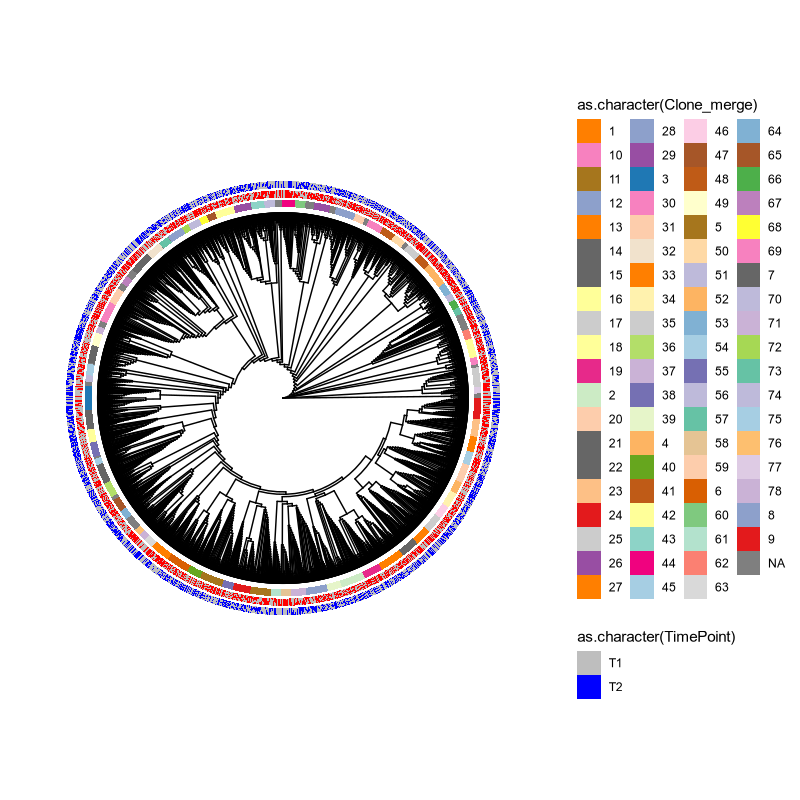

In [30]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=100)
print(p1)

# HSC clone VS state 

In [32]:
cell_state_meta<-Tomerge_v2(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.wnn@cell.embeddings,
           Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.rna@cell.embeddings) %>% 
           Tomerge_v2(.,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@reductions$umap.H.atac@cell.embeddings) %>% Tomerge_v2(.,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data[,c("STD.CellType","TimePoint","seurat_clusters","wsnn_res.0.2","wsnn_res.0.6")])

clone_state_meta<-Young1_T1T2_RigHSC_redeemR.sensitive@CellMeta %>% mutate(Cell=Translate_simple_ATAC2RNA(Cell)) %>% tibble::column_to_rownames("Cell") %>% .[,c("meanCov","Clone_merge")] %>% Tomerge_v2(cell_state_meta,.)

The following `from` values were not present in `x`: 1, 2, 3



In [35]:
## Seperate Time point 1(T1) and Time point 2(T2)
clone_state_meta.T1<-subset(clone_state_meta,TimePoint=="T1")
clone_state_meta.T2<-subset(clone_state_meta,TimePoint=="T2")

Define two functions **ComputeCoupling** and **PlotCoupling** to analyze the coupling between HSC clone and state(wnn based HSC subpopulations):

In [68]:
## A metadata, at least needs two column, one is the clone, one is the cell state cluster
## The column of clone is always Clone_merge
## Based on hypergeometric test
ComputeCoupling<-function(Clone_Module_meta,col.cellstate="seurat_clusters",cut=0.05){
Clone_Module_meta.Valid<-Clone_Module_meta[complete.cases(Clone_Module_meta),]
pvalueMartrix<-c()
pvalueMartrix_hg<-c()  
pvalueMartrix_exact<-c()  
Log2FoldMatrix<-c()
Clones<-unique(Clone_Module_meta$Clone_merge[!is.na(Clone_Module_meta$Clone_merge)]) %>% .[order(.)]
for(j in Clones){
ps<-table(Clone_Module_meta.Valid[,col.cellstate]) %>% prop.table %>% as.array
ps.names<-names(ps)
group<-subset(Clone_Module_meta.Valid,Clone_merge==j)
group.total<-nrow(group)
pvalues<-c()
pvalues_hg<-c()
pvalues_exact<-c()
Log2Folds<-c()
for(i in 1:length(ps)){
    p<-ps[i]
    x<-sum(group[,col.cellstate]==ps.names[i])
    md<-binom.test(x,group.total,p)
    pvalue<-md$p.value
    log2Fold<-log2(md$estimate/p)
    #Calculate hypergeometric p values
    q<-sum(group[,col.cellstate]==names(ps)[i])
    m<-sum(Clone_Module_meta.Valid[,col.cellstate]==names(ps)[i])
    n<-sum(Clone_Module_meta.Valid[,col.cellstate]!=names(ps)[i])
    k<-q+sum(group[,col.cellstate]!=names(ps)[i])
    pvalue_hg<-phyper(q,m,n,k,lower.tail = F)
    pvalue_exact<-fisher.test(matrix(c(q,(m-q),(k-q),(n-k+q)),2,2),alternative = "greater")$p
    pvalues<-c(pvalues,pvalue)
    pvalues_hg<-c(pvalues_hg,pvalue_hg)
    pvalues_exact<-c(pvalues_exact,pvalue_exact)
    Log2Folds<-c(Log2Folds,log2Fold) 
}
pvalueMartrix<-rbind(pvalueMartrix,pvalues)
pvalueMartrix_hg<-rbind(pvalueMartrix_hg,pvalues_hg)
pvalueMartrix_exact<-rbind(pvalueMartrix_exact,pvalues_exact)    
Log2FoldMatrix<-rbind(Log2FoldMatrix,Log2Folds)
}
row.names(pvalueMartrix)<-paste("C",Clones,sep="")
row.names(pvalueMartrix_hg)<-paste("C",Clones,sep="")
row.names(pvalueMartrix_exact)<-paste("C",Clones,sep="")    
row.names(Log2FoldMatrix)<-paste("C",Clones,sep="")
colnames(Log2FoldMatrix)<-paste("HSC",ps.names,sep="")
colnames(pvalueMartrix)<-paste("HSC",ps.names,sep="")
colnames(pvalueMartrix_hg)<-paste("HSC",ps.names,sep="")
colnames(pvalueMartrix_exact)<-paste("HSC",ps.names,sep="")
Log2FoldMatrix2Show<-Log2FoldMatrix
Log2FoldMatrix2Show[which(pvalueMartrix>=cut)]<-0
pvalueMartrix2Show<-pvalueMartrix
pvalueMartrix2Show[which(pvalueMartrix>=cut)]<-1
pvalueMartrix2Show_hg<-pvalueMartrix_hg
pvalueMartrix2Show_hg[which(pvalueMartrix_hg>=cut)]<-1
colnames(Log2FoldMatrix2Show)<-paste("HSC",ps.names,sep="")
colnames(pvalueMartrix2Show)<-paste("HSC",ps.names,sep="")
colnames(pvalueMartrix2Show_hg)<-paste("HSC",ps.names,sep="")    
return(list(pvalueMartrix=pvalueMartrix,Log2FoldMatrix=Log2FoldMatrix,Log2FoldMatrix2Show=Log2FoldMatrix2Show,pvalueMartrix2Show=pvalueMartrix2Show,pvalueMartrix_hg=pvalueMartrix_hg,pvalueMartrix2Show_hg=pvalueMartrix2Show_hg,pvalueMartrix_exact=pvalueMartrix_exact))
}

## This function plot the scatter
PlotCoupling<-function(Clone_Module_meta,res,conflict){
RNAmoduleSize<-table(Clone_Module_meta$seurat_clusters) %>% as.array
names(RNAmoduleSize)<-paste("HSC",names(RNAmoduleSize),sep="")
RNAmodule.order<-names(RNAmoduleSize)[order(RNAmoduleSize)]
Log2FoldMatrix2Show.sort<-res$Log2FoldMatrix2Show
pvalueMartrix2Show.sort<-res$FDR_FisherMethod_toshow
for(i in 1:nrow(conflict)){
pvalueMartrix2Show.sort[conflict[i,1],conflict[i,2]]<-1
}
Log2FoldMatrix2Show.sort<-Log2FoldMatrix2Show.sort[,RNAmodule.order] %>% .[order(abs(.[,1]),.[,2],.[,3],.[,4],.[,5],.[,6],.[,7],.[,8],.[,9],.[,10],.[,11],.[,12],.[,13],.[,14],decreasing=T),]
pvalueMartrix2Show.sort<-pvalueMartrix2Show.sort[,RNAmodule.order] %>% .[order(abs(.[,1]),.[,2],.[,3],.[,4],.[,5],.[,6],.[,7],.[,8],.[,9],.[,10],.[,11],.[,12],.[,13],.[,14],decreasing=T),]    
datatoplot<-melt(pvalueMartrix2Show.sort) %>% mutate(Name=paste(Var1,Var2,sep="-"))
ggplot(datatoplot)+aes(Var2,Var1,fill=-log10(value))+geom_tile(color="grey")+scale_fill_viridis()+coord_flip()  
}    

## run fisher's method to combine p-values from two time points
runfisher<-function(x,y){
    result<-fisher(c(x,y))$p
    return(result)
}

In [54]:
## HSC clone-state coupleing results
res<-ComputeCoupling(clone_state_meta,col.cellstate="seurat_clusters",cut=0.05)
res.T1<-ComputeCoupling(clone_state_meta.T1,col.cellstate="seurat_clusters",cut=0.05)
res.T2<-ComputeCoupling(clone_state_meta.T2,col.cellstate="seurat_clusters",cut=0.05)

In [56]:
## Compute Fisher's method p value and adjust p value using qvalue
res$FDR_FisherMethod<-mapply(runfisher,res.T1$pvalueMartrix_hg,res.T2$pvalueMartrix_hg) %>% qvalue %>% .$qvalues %>% matrix(.,dim(res$pvalueMartrix_hg))
res$p_FisherMethod<-mapply(runfisher,res.T1$pvalueMartrix_hg,res.T2$pvalueMartrix_hg) %>% matrix(.,dim(res$pvalueMartrix_hg))
row.names(res$FDR_FisherMethod)<-row.names(res$pvalueMartrix_hg)
colnames(res$FDR_FisherMethod)<-colnames(res$pvalueMartrix_hg)
row.names(res$p_FisherMethod)<-row.names(res$pvalueMartrix_hg)
colnames(res$p_FisherMethod)<-colnames(res$pvalueMartrix_hg)

In [57]:
## use p_FisherMethod<0.01, FDR<0.05, log2(t1) fold >0.25,  log2(t2) fold >0.25
res$p_FisherMethod_toshow<-res$p_FisherMethod
res$FDR_FisherMethod_toshow<-res$FDR_FisherMethod
res$p_FisherMethod_toshow[!(res$p_FisherMethod<0.01 & (res.T1$Log2FoldMatrix>0.25 & res.T2$Log2FoldMatrix>0.25))]<-1
res$FDR_FisherMethod_toshow[!(res$p_FisherMethod<0.01 & (res.T1$Log2FoldMatrix>0.25 & res.T2$Log2FoldMatrix>0.25))]<-1
# Print out the identified significant clone~subpopulation pair
which(res$p_FisherMethod<0.01 & (res.T1$Log2FoldMatrix>0.25 & res.T2$Log2FoldMatrix>0.25))

[1]   71   73   77   81  137  183  285  384  397  422  458  473  513  548  603
[16]  646  672  710  748  803  815  817  820  836  886  919  969 1043 1045 1069
[31] 1091

## Main Fig.3g

Selecting by Name


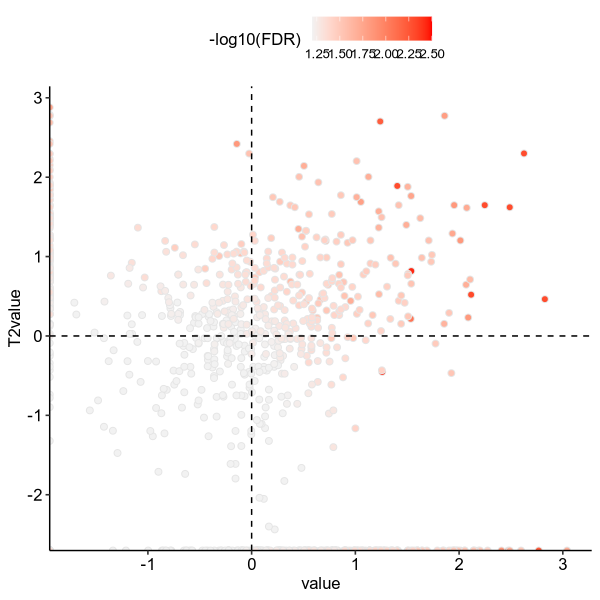

In [64]:
## Plot for T1,T2 fold change with overall T1+T2 p values
datatoplot<-melt(res.T1$Log2FoldMatrix) %>% mutate(T2value=melt(res.T2$Log2FoldMatrix)[,3]) %>% 
mutate(pvalue.t1=melt(res.T1$pvalueMartrix_hg)[,"value"],pvalue.t2=melt(res.T2$pvalueMartrix_hg)[,"value"],
       pvalue.combine=melt(res$p_FisherMethod)[,"value"],FDR=melt(res$FDR_FisherMethod)[,"value"]) %>%  mutate(Fold=value*T2value) %>% mutate(Name=paste(Var1,Var2,sep="-"))
ToShow<-subset(datatoplot,!is.infinite(Fold) &value>1 & T2value>1 & FDR>1.3) %>% group_by(Var2) %>% top_n(.,2) %>% .$Name
datatoplot<-datatoplot %>% mutate(Label=ifelse(Name %in% ToShow,Name,""))

# options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=100)
ggplot(datatoplot)+aes(value,T2value,fill=-log10(FDR),label=Label)+geom_point(color="grey90",shape=21,size=2)+geom_vline(xintercept = 0,linetype=2)+geom_hline(yintercept = 0,linetype=2)+
scale_fill_gradient(high="red",low="grey95",limit=c(1.2,2.5),oob=scales::squish)+theme_pubr()#+geom_text_repel(size=2)


## Supplementary data 4

In [65]:
datatoreport<-datatoplot %>% select(Var1,Var2,value,T2value,pvalue.t1,pvalue.t2,pvalue.combine,FDR, Name) %>% 
    rename(ClonalGroup=Var1,Subpopulation=Var2,Log2FC.T1=value, Log2FC.T2=T2value,
       Pvalue.T1=pvalue.t1,Pvalue.T2=pvalue.t2,Pvalue.combine=pvalue.combine)

In [ ]:
head(datatoreport)

## Main Fig. 3f

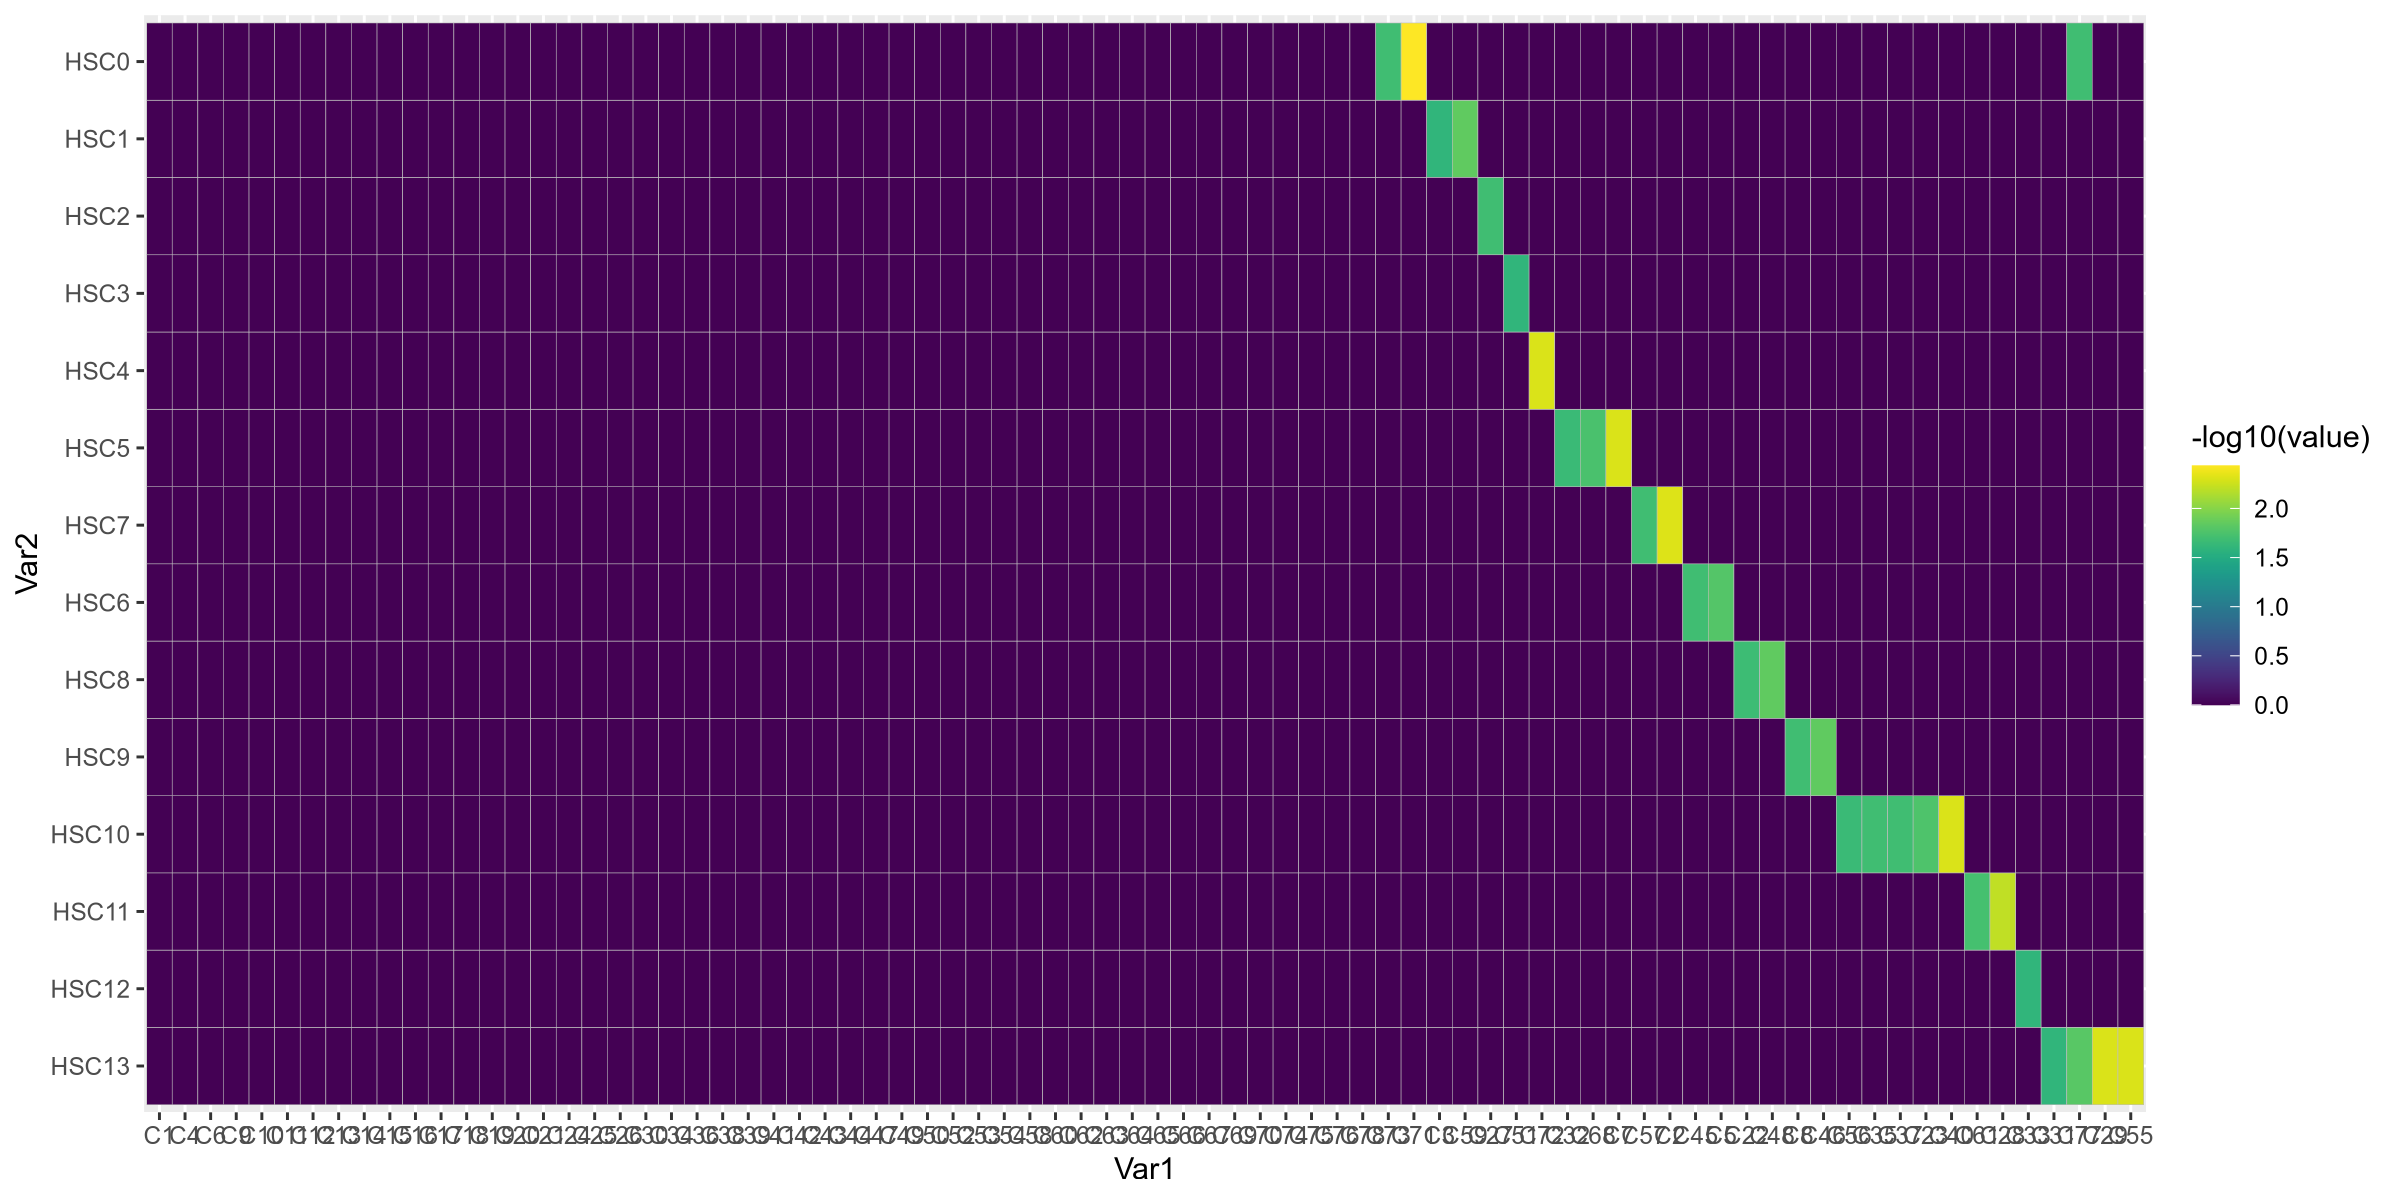

In [69]:
Conflict.pairs<-subset(datatoplot,Fold<0)
options(repr.plot.width=12, repr.plot.height=6,repr.plot.res=200)
PlotCoupling(clone_state_meta,res,Conflict.pairs)

## Main Fig. 3d

In [75]:
## Define functions for bubble plot
bubblePrep<-function(data,meta,cpcol,donormalscale=T)
{
	Nonzeroratio.cal<-function(vector)
	{
		nonzero.n<-length(which(vector>0))
		nonzero.ratio<-nonzero.n/length(vector)
	}
		data[is.na(data)]<-0
		result<-data.frame()
		for (groupname in unique(meta[,cpcol]))
		{
			tmpdata<-data[,row.names(subset(meta,get(cpcol)==groupname))]
			tmpresult<-data.frame(gene=row.names(tmpdata),groupname=groupname,nonzeroratio=apply(tmpdata,1,Nonzeroratio.cal)/100*mean(apply(tmpdata,1,Nonzeroratio.cal)),nTrance=apply(tmpdata,1,mean)/(mean(apply(tmpdata,1,mean))*10),row.names=NULL)
			result<-rbind(result,tmpresult)
		}
    if(donormalscale)
		{
			scaled.result=c()
			n=1
				for(curgene in unique(result$gene))
				{
					scaled.result<-rbind(scaled.result,data.frame(gene=subset(result,gene==curgene)[,1],groupname=subset(result,gene==curgene)[,2],nonzeroratio=subset(result,gene==curgene) %>% .[,4] %>% scale, nTrance=subset(result,gene==curgene) %>% .[,4] %>% scale))
					# print(n)
					# n=n+1
				}
				result<-scaled.result
		}
	return(result)
}

In [76]:
BubbleData<-bubblePrep(Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@assays$SCT@data,Young1_RigHSC_T1T2_Multiome_wrapper_filtered.anno.hm@meta.data,"seurat_clusters")

In [77]:
features<-c("MECOM","FTH1","BMP6","FLT3","CDK6","RPS4X","RPS18","RPL10","ELMO1","JUN","FOS","MED12L")

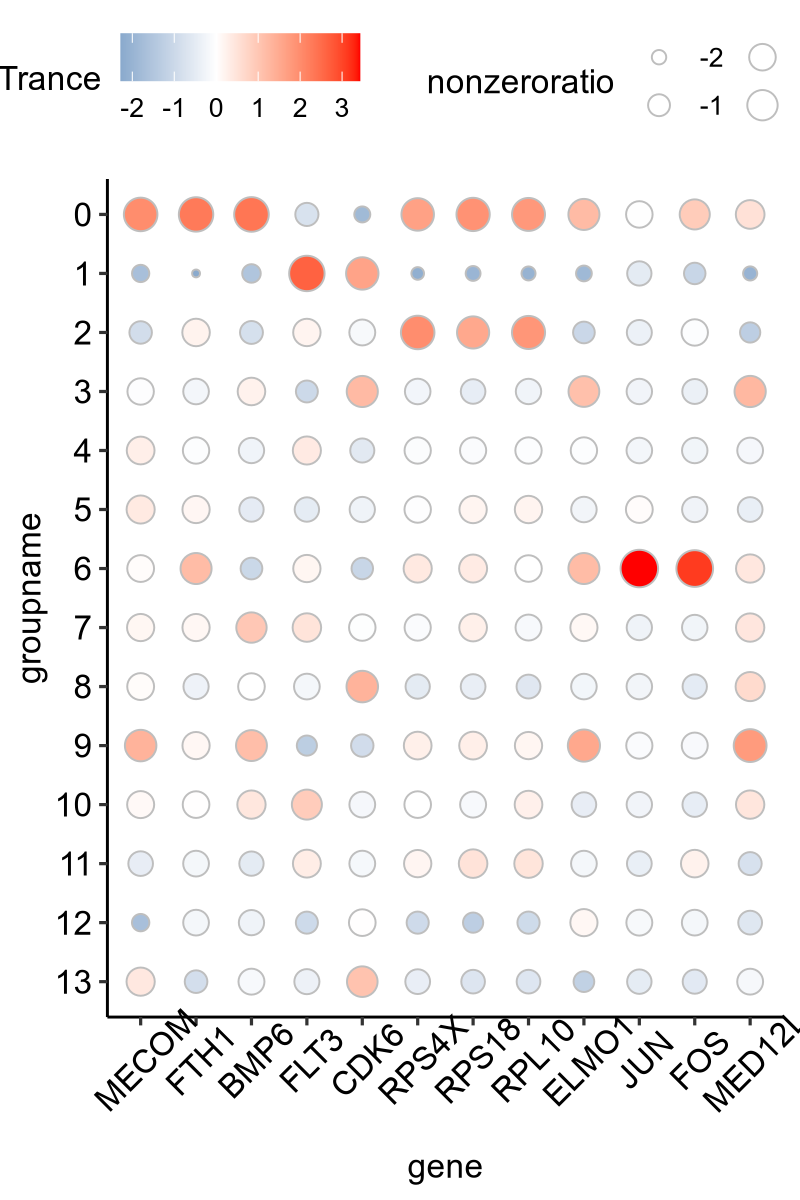

In [78]:
options(repr.plot.width=4, repr.plot.height=6,repr.plot.res=200)
Datatoplot<-subset(BubbleData,gene %in% features) 
Datatoplot$gene<-factor(Datatoplot$gene,levels=unique(features))
Datatoplot$groupname<-factor(Datatoplot$groupname,levels=rev(as.character(0:13)))
Datatoplot<-Datatoplot[complete.cases(Datatoplot),]
#pdf("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/PDFs/HSC_heterogeneity/2022-4-26-2.pdf",width=14,height=8)
p<-ggplot(Datatoplot)+aes(groupname,gene,fill=nTrance,size=nonzeroratio)+geom_point(shape=21,color="grey")+scale_fill_gradient2(high="red",low="steelblue",mid="white")+coord_flip()+theme_pubr()+theme(axis.text.x = element_text(angle = 45,vjust = 0.8))
print(p)
#dev.off()